In [1]:
import io, os, re, logging
import requests, tqdm, tarfile, itertools, html, time
from dateparser.date import DateDataParser
from dateparser import parse

import numpy as np
import pandas as pd
import dask.dataframe as dd

import plotly.express as px
import plotly.graph_objects as go

# Import Dataset

In [2]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_72877shots_2021-11-11_cleaned.parquet")
shots_df

,id,profile_title,user_id,drink_tds,drink_ey,espresso_enjoyment,bean_weight,drink_weight,grinder_model,grinder_setting,...,espresso_state_change,espresso_pressure_goal,espresso_flow_weight_raw,espresso_temperature_mix,espresso_water_dispensed,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket,bean_age,shot_time
0,14899484-a5f8-4ccc-b372-79700c8150ae,TurboBloom,8d827d10-510f-4475-bd54-63c93b275c16,0.0,0.0,80.0,15.0,35.2,P64 MP,1.4,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 86.67, 86.31, 82.06, 77.66, 74.73, 73.1...","[0.0, 0.092681884765625, 0.20140380859375, 0.3...","[86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 85.12, 85.27, 85.49, 85.38, 85.35, 85.3...",NaN,18.493
1,76f936ee-5147-40ac-986e-f0f1be5ac97e,Best overall pressure profile,10f1e281-8fd0-4f43-94f6-d416713dabe0,0.0,0.0,0.0,18.0,36.1,bentwood,120,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 88.3, 85.79, 85.82, 86.44, 87.32, 88.0,...","[0.0, 0.09389038085937501, 0.18845825195312502...","[88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 87.18, 87.39, 87.37, 87.31, 87.23, 87.0...",NaN,29.475
2,8853ae7c-5bf8-4194-93dd-462de63f1471,Default,30b3dd10-aebb-4f17-ba74-a1efcf2d51ea,0.0,0.0,0.0,NaN,40.3,None,None,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 89.87, 87.2, 87.69, 87.95, 87.98, 88.18...","[0.0, 0.10127563476562501, 0.20233764648437502...","[90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 87.93, 88.21, 88.23, 88.16, 88.14, 88.1...",NaN,35.054
3,a4d7a358-fc3f-451c-92f5-756adaa4a7dd,Rao Allongé,c8c4793c-6708-4e81-90e8-6d8a5b30ceee,0.0,0.0,0.0,NaN,124.5,Niche Zero,13.5,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 91.63, 88.9, 87.29, 88.18, 89.33, 90.63...","[0.0, 0.094384765625, 0.19187011718750002, 0.2...","[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 90.0, 90.41, 90.36, 90.35, 90.44, 90.4,...",NaN,40.996
4,3ebcfff9-fb6f-47f6-a3df-affe01d55150,Londonium,db110ce3-77b7-4c92-9d18-1019c3841cc9,0.0,0.0,0.0,NaN,0.0,None,None,...,"[0.0, 10000000.0, -10000000.0, -10000000.0, -1...","[-1.0, 2.0, 2.0, 2.375, 2.625, 2.75, 2.8125, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 89.64, 87.11, 87.89, 88.81, 89.41, 89.6...","[0.0, 0.09944458007812501, 0.21490478515625, 0...","[89.0, 89.0, 88.5, 88.5, 88.5, 88.5, 88.5, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 87.55, 87.81, 87.75, 87.76, 87.8, 87.74...",NaN,38.787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72872,7ecca37f-2dae-429e-9947-b3ee08793b78,Gentle and sweet,b51718ab-bc11-463d-be90-5538921b05e4,9.5,0.0,65.0,18.0,39.8,Sette 270Wi,6E,...,None,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, -0.05, -0.05, -0.05, -0.05, -0.05, ...","[92.0, 92.79, 90.69, 88.64, 89.55, 90.82, 91.9...","[0.0, 0.0509765625, 0.111627197265625, 0.18171...","[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....",None,"[92.0, 92.61, 92.53, 92.24, 91.6, 90.83, 90.06...",12.440278,26.777
72873,7bf138f6-8fb9-41c9-a513-74874115684f,Blooming Allongé,b51718ab-bc11-463d-be90-5538921b05e4,5.2,0.0,60.0,18.0,89.2,Sette 270Wi,7E,...,None,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, -0.05, -0.05, -0.05, -0.05, -0.05, ...","[94.0, 93.37, 89.01, 90.15, 91.73, 92.96, 93.8...","[0.0, 0.05553588

In [3]:
shots_df.dtypes

id                                     object
profile_title                          object
user_id                                object
drink_tds                             float64
drink_ey                              float64
espresso_enjoyment                    float64
bean_weight                           float64
drink_weight                          float64
grinder_model                          object
grinder_setting                        object
bean_brand                             object
bean_type                              object
roast_date                     datetime64[ns]
espresso_notes                         object
roast_level                            object
bean_notes                             object
start_time                     datetime64[ns]
image_preview                          object
profile_url                            object
timeframe                              object
espresso_flow                          object
espresso_weight                   

# Visualize distribution of features

In [ ]:
pos_ratings = shots_df["espresso_enjoyment"][shots_df["espresso_enjoyment"]!=0]
px.histogram(pos_ratings, 
             title=f"Distribution of espresso_enjoyment user ratings."
             f"<br># of pos ratings = {pos_ratings.shape[0]}, # of 0 or null ratings = {(shots_df['espresso_enjoyment']==0).shape}").show(renderer="png")

In [ ]:
fig = px.histogram(shots_df.groupby("user_id")["id"].count().sort_values(), title=f"Distribution of number of shots across {shots_df['user_id'].nunique()} user.")
fig.update_layout(xaxis_title="# of espressos made per user", yaxis_title="Number of users").show(renderer="png")

In [ ]:
fig = px.strip(shots_df[shots_df["espresso_enjoyment"]!=0].sort_values("start_time"), 
               x="user_id", y="espresso_enjoyment",
               height=500,width=2000,
               title="Distribution of ratings per user, sorted by `start_time`")
fig.update_xaxes(
    visible=False
)
fig.show(renderer="png")

In [ ]:
most_popular_profiles = shots_df["profile_title"].value_counts()[:20]
most_popular_profiles

In [ ]:
df = shots_df[shots_df["profile_title"].isin(most_popular_profiles.index[:14])]
df = df[df["espresso_enjoyment"]!=0]
fig = px.violin(df, x="profile_title", y="espresso_enjoyment", #facet_col="profile_title",
               height=500,width=2000, color="profile_title",
               title="Distribution of ratings per profile")
fig.show(renderer="png")

In [ ]:
df = shots_df[shots_df["profile_title"].isin(most_popular_profiles.index[:12])]

fig = px.box(df, x="shot_time", y="profile_title", #facet_col="profile_title",
               height=500, width=2000, color="profile_title",
               title="Distribution of shot duration per profile")
fig.show(renderer="png")

In [ ]:
px.scatter(shots_df[(shots_df["espresso_enjoyment"]!=0) & shots_df["roast_level"].isin(['Medium', 'Light', 'medium', 
                                                                                        'light', 'dark', 'Med', 'espresso',
                                                                                        'Medium-Light', 'Medium Light'])], 
           x="bean_age", y="espresso_enjoyment", color="roast_level", width=1500).show(renderer="png")

# Visualize shot series

In [4]:
timeseries_cols = ["timeframe", 'espresso_flow',
       'espresso_weight', 'espresso_pressure', 'espresso_flow_goal',
       'espresso_resistance', 'espresso_flow_weight', 'espresso_state_change',
       'espresso_pressure_goal', 'espresso_flow_weight_raw',
       'espresso_temperature_mix', 'espresso_water_dispensed',
       'espresso_temperature_goal', 'espresso_resistance_weight',
       'espresso_temperature_basket']

In [32]:
def timeseries_to_df(values, timeframe):
    time_index = pd.TimedeltaIndex(timeframe, unit="seconds", name="seconds")
    some_series = values[list(values.keys())[0]]

    return pd.DataFrame(values, index=time_index)

In [33]:
shot_series = shots_df[timeseries_cols].sample(50).apply(lambda row: timeseries_to_df(row[1:].to_dict(), timeframe=row.timeframe), 
                                                         axis=1)
shot_series = pd.concat(shot_series.to_dict(), names=["id"])
shot_series.head()

espresso_flow  espresso_weight  \
id    seconds                                                  
30708 0 days 00:00:00                  0.00              0.0   
      0 days 00:00:00.044000           2.33              0.0   
      0 days 00:00:00.314000           2.47              0.0   
      0 days 00:00:00.584000           2.93              0.0   
      0 days 00:00:00.809000           3.62              0.0   

                              espresso_pressure  espresso_flow_goal  \
id    seconds                                                         
30708 0 days 00:00:00                       0.0             -1.0000   
      0 days 00:00:00.044000                0.0              2.7500   
      0 days 00:00:00.314000                0.0              4.5625   
      0 days 00:00:00.584000                0.0              5.7500   
      0 days 00:00:00.809000                0.0              6.5625   

                              espresso_resistance  espresso_flow_weight  \
id    seconds                                                             
30708 0 days 00:00:00                         0.0                   0.0   
      0 days 00:00:00.044000                  0.0                   0.0   
      0 days 00:00:00.314000                  0.0                   0.0   
      0 days 00:00:00.584000                  0.0                   0.0   
      0 days 00:00:00.809000                  0.0                   0.0   

                              espresso_state_change  espresso_pressure_goal  \
id    seconds                                                                 
30708 0 days 00:00:00                           0.0                    -1.0   
      0 days 00:00:00.044000             10000000.0                    -1.0   
      0 days 00:00:00.314000             10000000.0                    -1.0   
      0 days 00:00:00.584000             10000000.0                    -1.0   
      0 days 00:00:00.809000             10000000.0                    -1.0   

                              espresso_flow_weight_raw  \
id    seconds                                            
30708 0 days 00:00:00                              0.0   
      0 days 00:00:00.044000                       0.0   
      0 days 00:00:00.314000                       0.0   
      0 days 00:00:00.584000                       0.0   
      0 days 00:00:00.809000                       0.0   

                              espresso_temperature_mix  \
id    seconds                                            
30708 0 days 00:00:00                            93.00   
      0 days 00:00:00.044000                     94.51   
      0 days 00:00:00.314000                     94.58   
      0 days 00:00:00.584000                     94.54   
      0 days 00:00:00.809000                     94.03   

                              espresso_water_dispensed  \
id    seconds                                            
30708 0 days 00:00:00                         0.000000   
      0 days 00:00:00.044000                  0.058307   
      0 days 00:00:00.314000                  0.120074   
      0 days 00:00:00.584000                  0.193268   
      0 days 00:00:00.809000                  0.283832   

                              espresso_temperature_goal  \
id    seconds                                             
30708 0 days 00:00:00                              93.0   
      0 days 00:00:00.044000                       93.0   
      0 days 00:00:00.314000                       93.0   
      0 days 00:00:00.584000                       93.0   
      0 days 00:00:00.809000                       93.0   

                              espresso_resistance_weight  \
id    seconds                                              
30708 0 days 00:00:00                                0.0   
      0 days 00:00:00.044000                         0.0   
      0 days 00:00:00.314000                         0.0   
      0 days 00:00:00.584000                         0.0   
      0 

In [66]:
shot_series_agg = shot_series.reset_index().groupby([pd.Grouper(key='seconds', freq='500L')])[timeseries_cols[1:]].median()
shot_series_agg

,espresso_flow,espresso_weight,espresso_pressure,espresso_flow_goal,espresso_resistance,espresso_flow_weight,espresso_state_change,espresso_pressure_goal,espresso_flow_weight_raw,espresso_temperature_mix,espresso_water_dispensed,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket
seconds,,,,,,,,,,,,,,
0 days 00:00:00,3.900,0.00,0.140,-1.0000,0.01,0.00,0.0,-1.0,0.00,92.270,0.096405,92.0,0.000,91.370
0 days 00:00:00.500000,5.270,0.00,0.490,3.5000,0.01,0.00,10000000.0,-1.0,0.00,90.800,0.393658,92.0,0.000,90.370
0 days 00:00:01,6.210,0.00,0.605,3.9375,0.01,0.00,10000000.0,-1.0,0.00,91.180,0.690134,92.0,0.000,90.395
0 days 00:00:01.500000,6.245,0.00,0.730,3.7500,0.02,0.00,10000000.0,-1.0,0.00,91.375,0.992714,92.0,0.000,90.215
0 days 00:00:02,6.560,0.00,0.750,3.9375,0.02,0.00,10000000.0,-1.0,0.00,92.440,1.329449,92.0,0.000,90.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:02:02,7.920,-156.91,6.715,11.0000,0.11,-0.02,10000000.0,-1.0,-0.02,93.420,33.337366,95.0,16787.110,98.640
0 days 00:02:02.500000,7.925,-156.91,6.690,11.0000,0.11,-0.02,10000000.0,-1.0,-0.02,93.100,33.734048,95.0,16727.600,98.465
0 days 00:02:03,7.890,-156.91,6.640,11.0000,0.11,-0.02,10000000.0,-1.0,-0.02,92.825,34.128806,95.0,16596.375,98.250


In [55]:
# shot = shot_series.loc[8304]
series = shot
series["seconds"] = series.index / pd.Timedelta(1, "s")
series

,espresso_flow,espresso_weight,espresso_pressure,espresso_flow_goal,espresso_resistance,espresso_flow_weight,espresso_state_change,espresso_pressure_goal,espresso_flow_weight_raw,espresso_temperature_mix,espresso_water_dispensed,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket,seconds
seconds,,,,,,,,,,,,,,,
0 days 00:00:00,4.005,0.00,0.270,-1.0000,0.01,0.00,10000000.0,-1.0,0.00,91.785,0.195865,92.0,0.000,90.815,0.0
0 days 00:00:01,6.235,0.00,0.640,3.9375,0.02,0.00,10000000.0,-1.0,0.00,91.275,0.802311,92.0,0.000,90.260,1.0
0 days 00:00:02,6.660,0.00,0.740,3.5000,0.02,0.00,10000000.0,-1.0,0.00,92.880,1.472310,92.0,0.000,90.590,2.0
0 days 00:00:03,6.670,0.00,0.890,3.5000,0.02,0.00,10000000.0,-1.0,0.00,92.510,2.152368,92.0,0.000,91.280,3.0
0 days 00:00:04,6.020,0.00,1.220,2.0625,0.03,0.00,-10000000.0,-1.0,0.00,92.650,2.770313,92.0,0.000,91.640,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:02:00,8.095,-156.91,6.785,11.0000,0.10,-0.02,10000000.0,-1.0,-0.02,94.685,31.942584,95.0,16963.805,99.455,120.0
0 days 00:02:01,7.960,-156.91,6.715,11.0000,0.11,-0.02,10000000.0,-1.0,-0.02,93.900,32.743494,95.0,16777.950,99.080,121.0
0 days 00:02:02,7.925,-156.91,6.710,11.0000,0.11,-0.02,10000000.0,-1.0,-0.02,93.235,33.535870,95.0,16777.345,98.570,122.0


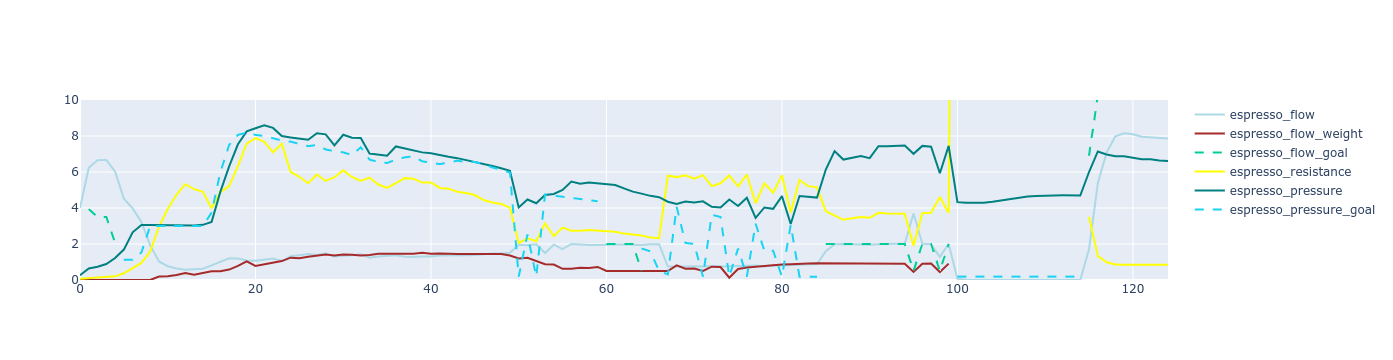

In [64]:
time_index = series["seconds"]
series["espresso_resistance"] = series["espresso_pressure"]/series["espresso_flow"]
series[series<0] = None

fig = go.Figure()
fig.add_scatter(x=time_index, y=series['espresso_flow'], mode='lines', name="espresso_flow", line={"color":"lightblue"})
fig.add_scatter(x=time_index, y=series['espresso_flow_weight'], mode='lines', name="espresso_flow_weight", line={"color":"brown"})
fig.add_scatter(x=time_index, y=series['espresso_flow_goal'], mode='lines', name="espresso_flow_goal", line={"dash": "dash"})

fig.add_scatter(x=time_index, y=series['espresso_resistance'], mode='lines', name="espresso_resistance", line={"color":"yellow"})

fig.add_scatter(x=time_index, y=series['espresso_pressure'], mode='lines', name="espresso_pressure", line={"color":"teal"})
fig.add_scatter(x=time_index, y=series['espresso_pressure_goal'], mode='lines', name="espresso_pressure_goal", line={"dash": "dash"})

fig.update_layout(hovermode="x")
fig.update_yaxes(range=[0, 10])
fig